# sprint22　Object detection
### simpsons の画像や動画に対してオブジェクトディテクション(キャラクターの位置と種類の特定)を行う
### 使用するモデル：SSD

In [22]:
import cv2
import keras
from keras.applications.imagenet_utils import preprocess_input
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.preprocessing import image as kimage
import matplotlib.pyplot as plt
import numpy as np
import pickle
from random import shuffle
from scipy.misc import imread
from scipy.misc import imresize
import tensorflow as tf
import ffmpeg
from ssd import SSD300
from ssd_training import MultiboxLoss
from ssd_utils import BBoxUtility

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'

np.set_printoptions(suppress=True)


アノテーションリストを読み込む

In [2]:
with open("../input/the-simpsons-characters-dataset/annotation.txt",'r') as f :
    file = f.read()

何体のキャラクターアノテーションがあるかを調べる  
そのために、文字列から名前の箇所だけを取り出す（カンマで分割→座標を除外→改行で分割）

In [3]:
spli = file.split(',')
name = []
for i in range(1,len(spli)):#文字列の０行目だけ他と異なる文字列になるので除外し、1行目から
    if not spli[i].isdigit():
        name.append(spli[i].split('\n')[0])

名前の重複を取り除いて数を調べる（結果は１８体）

In [4]:
len(set(name))

18

SSD内部では上のどのクラスにも該当しないものを１クラスとして扱うのでSSDには１増やした数をクラス数として与える

In [5]:
NUM_CLASSES = 18+1

キャラクターごとのアノテーション数

In [6]:
import collections
chara_names = collections.Counter(name)
names_dict = dict(chara_names)
names_dict

{'abraham_grampa_simpson': 595,
 'apu_nahasapeemapetilon': 206,
 'bart_simpson': 554,
 'charles_montgomery_burns': 650,
 'chief_wiggum': 209,
 'comic_book_guy': 208,
 'edna_krabappel': 212,
 'homer_simpson': 612,
 'kent_brockman': 213,
 'krusty_the_clown': 226,
 'lisa_simpson': 562,
 'marge_simpson': 557,
 'milhouse_van_houten': 210,
 'moe_szyslak': 215,
 'ned_flanders': 595,
 'nelson_muntz': 219,
 'principal_skinner': 506,
 'sideshow_bob': 203}

キャラクターのラベル辞書を作成

In [7]:
name_label = dict()
for i, name in enumerate(names_dict.keys()):
    name_label[name]=i
name_label

{'abraham_grampa_simpson': 0,
 'apu_nahasapeemapetilon': 1,
 'bart_simpson': 2,
 'charles_montgomery_burns': 3,
 'chief_wiggum': 4,
 'comic_book_guy': 5,
 'edna_krabappel': 6,
 'homer_simpson': 7,
 'kent_brockman': 8,
 'krusty_the_clown': 9,
 'lisa_simpson': 10,
 'marge_simpson': 11,
 'milhouse_van_houten': 12,
 'moe_szyslak': 13,
 'ned_flanders': 14,
 'nelson_muntz': 15,
 'principal_skinner': 16,
 'sideshow_bob': 17}

{画像パス：正解データ（bounding box座標＋該当クラスone_hot表現）}の形の辞書を作成する  
そのために、まず、アノテーションリストから画像バスと座標データを取り出す

In [9]:
spli = file.split(',')
gt = dict()
#num = 0
count = 0
coordinate = []
for i in range(len(spli)):
    if spli[i].isdigit():
        coordinate.append(int(spli[i]))
        count +=1
    else:
        #文字列の場合は改行後の部分を記録しておく（0行目だけは改行がない）
        if '\n' in spli[i]:
            key = spli[i].split('\n')[1][2:]
        else:
            key = spli[i][2:]
    if 4<=count:
        key = 'characters' + '/' + key.split('/')[1] + '/' + key.split('/')[2]
        #ターゲット座標の値を画像内での高さと幅における比率に直す 
        
        image = cv2.imread('../input/the-simpsons-characters-dataset/'+ key)
        h, w, _ = image.shape#画像のサイズ(h,w,c)
        if (coordinate[0]<coordinate[2]) and (coordinate[1]<coordinate[3]):
            coordinate[0] /= w
            coordinate[1] /= h
            coordinate[2] /= w
            coordinate[3] /= h
            gt[key] = np.array(coordinate)
        #num +=1
        count = 0
        coordinate = []
gt

{'characters/abraham_grampa_simpson/pic_0001.jpg': array([0.16129032, 0.08423913, 0.67943548, 0.96195652]),
 'characters/abraham_grampa_simpson/pic_0002.jpg': array([0.44444444, 0.11538462, 0.98958333, 0.97836538]),
 'characters/abraham_grampa_simpson/pic_0003.jpg': array([0.25      , 0.29166667, 0.54861111, 0.63657407]),
 'characters/abraham_grampa_simpson/pic_0004.jpg': array([0.384375  , 0.12708333, 0.91875   , 0.86666667]),
 'characters/abraham_grampa_simpson/pic_0005.jpg': array([0.19965278, 0.04326923, 0.86458333, 0.99278846]),
 'characters/abraham_grampa_simpson/pic_0006.jpg': array([0.296875  , 0.11298077, 0.734375  , 0.99278846]),
 'characters/abraham_grampa_simpson/pic_0007.jpg': array([0.20833333, 0.12740385, 0.66145833, 0.98317308]),
 'characters/abraham_grampa_simpson/pic_0008.jpg': array([0.25868056, 0.13461538, 0.69097222, 0.97596154]),
 'characters/abraham_grampa_simpson/pic_0009.jpg': array([0.3203125 , 0.08836207, 0.734375  , 0.98275862]),
 'characters/abraham_grampa_

続いて、該当クラスのone-hot配列を結合させる

In [10]:
for key in gt.keys():
    character = key.split('/')[1]
    array0 = np.zeros(NUM_CLASSES-1)# 辞書ではキャラクター数分のone-hot表現のみ必要となるので−１する
    for name in name_label.keys():
        if character == name:
            array0[name_label[name]] = 1 # 該当箇所を１にする
    #座標の後ろに結合する
    gt[key] = np.hstack((gt[key],array0))[np.newaxis,:]
gt       

{'characters/abraham_grampa_simpson/pic_0001.jpg': array([[0.16129032, 0.08423913, 0.67943548, 0.96195652, 1.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ]]),
 'characters/abraham_grampa_simpson/pic_0002.jpg': array([[0.44444444, 0.11538462, 0.98958333, 0.97836538, 1.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ]]),
 'characters/abraham_grampa_simpson/pic_0003.jpg': array([[0.25      , 0.29166667, 0.54861111, 0.63657407, 1.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        

train用とvalidation用に分けておく 

In [11]:
import random
val_ratio = 0.2
keys = sorted(gt.keys())
random.shuffle(keys)
num_train = int(round((1-val_ratio) * len(keys)))
train_keys = keys[:num_train]
val_keys = keys[num_train:]

入力データ作成クラス

In [12]:
class Generator(object):
    def __init__(self, gt, bbox_util,
                 batch_size, path_prefix,
                 train_keys, val_keys, image_size,
                 saturation_var=0.5,
                 brightness_var=0.5,
                 contrast_var=0.5,
                 lighting_std=0.5,
                 hflip_prob=0.5,
                 vflip_prob=0.5,
                 do_crop=True,
                 crop_area_range=[0.75, 1.0],
                 aspect_ratio_range=[3./4., 4./3.]):
        self.gt = gt
        self.bbox_util = bbox_util
        self.batch_size = batch_size
        self.path_prefix = path_prefix
        self.train_keys = train_keys
        self.val_keys = val_keys
        self.train_batches = len(train_keys)
        self.val_batches = len(val_keys)
        self.image_size = image_size
        self.color_jitter = []
        if saturation_var:
            self.saturation_var = saturation_var
            self.color_jitter.append(self.saturation)
        if brightness_var:
            self.brightness_var = brightness_var
            self.color_jitter.append(self.brightness)
        if contrast_var:
            self.contrast_var = contrast_var
            self.color_jitter.append(self.contrast)
        self.lighting_std = lighting_std
        self.hflip_prob = hflip_prob
        self.vflip_prob = vflip_prob
        self.do_crop = do_crop
        self.crop_area_range = crop_area_range
        self.aspect_ratio_range = aspect_ratio_range
        
    def grayscale(self, rgb):
        return rgb.dot([0.299, 0.587, 0.114])

    def saturation(self, rgb):
        gs = self.grayscale(rgb)
        alpha = 2 * np.random.random() * self.saturation_var 
        alpha += 1 - self.saturation_var
        rgb = rgb * alpha + (1 - alpha) * gs[:, :, None]
        return np.clip(rgb, 0, 255)

    def brightness(self, rgb):
        alpha = 2 * np.random.random() * self.brightness_var 
        alpha += 1 - self.saturation_var
        rgb = rgb * alpha
        return np.clip(rgb, 0, 255)

    def contrast(self, rgb):
        gs = self.grayscale(rgb).mean() * np.ones_like(rgb)
        alpha = 2 * np.random.random() * self.contrast_var 
        alpha += 1 - self.contrast_var
        rgb = rgb * alpha + (1 - alpha) * gs
        return np.clip(rgb, 0, 255)

    def lighting(self, img):
        cov = np.cov(img.reshape(-1, 3) / 255.0, rowvar=False)
        eigval, eigvec = np.linalg.eigh(cov)
        noise = np.random.randn(3) * self.lighting_std
        noise = eigvec.dot(eigval * noise) * 255
        img += noise
        return np.clip(img, 0, 255)
    
    def horizontal_flip(self, img, y):
        if np.random.random() < self.hflip_prob:
            img = img[:, ::-1]
            y[:, [0, 2]] = 1 - y[:, [2, 0]]
        return img, y
    
    def vertical_flip(self, img, y):
        if np.random.random() < self.vflip_prob:
            img = img[::-1]
            y[:, [1, 3]] = 1 - y[:, [3, 1]]
        return img, y
    
    def random_sized_crop(self, img, targets):
        img_w = img.shape[1]
        img_h = img.shape[0]
        img_area = img_w * img_h
        random_scale = np.random.random()
        random_scale *= (self.crop_area_range[1] -
                         self.crop_area_range[0])
        random_scale += self.crop_area_range[0]
        target_area = random_scale * img_area
        random_ratio = np.random.random()
        random_ratio *= (self.aspect_ratio_range[1] -
                         self.aspect_ratio_range[0])
        random_ratio += self.aspect_ratio_range[0]
        w = np.round(np.sqrt(target_area * random_ratio))     
        h = np.round(np.sqrt(target_area / random_ratio))
        if np.random.random() < 0.5:
            w, h = h, w
        w = min(w, img_w)
        w_rel = w / img_w
        w = int(w)
        h = min(h, img_h)
        h_rel = h / img_h
        h = int(h)
        x = np.random.random() * (img_w - w)
        x_rel = x / img_w
        x = int(x)
        y = np.random.random() * (img_h - h)
        y_rel = y / img_h
        y = int(y)
        img = img[y:y+h, x:x+w]
        new_targets = []
        for box in targets:
            cx = 0.5 * (box[0] + box[2])
            cy = 0.5 * (box[1] + box[3])
            if (x_rel < cx < x_rel + w_rel and
                y_rel < cy < y_rel + h_rel):
                xmin = (box[0] - x_rel) / w_rel
                ymin = (box[1] - y_rel) / h_rel
                xmax = (box[2] - x_rel) / w_rel
                ymax = (box[3] - y_rel) / h_rel
                xmin = max(0, xmin)
                ymin = max(0, ymin)
                xmax = min(1, xmax)
                ymax = min(1, ymax)
                box[:4] = [xmin, ymin, xmax, ymax]
                new_targets.append(box)
        new_targets = np.asarray(new_targets).reshape(-1, targets.shape[1])
        return img, new_targets
    
    def generate(self, train=True):
        while True:
            if train:
                shuffle(self.train_keys)
                keys = self.train_keys
            else:
                shuffle(self.val_keys)
                keys = self.val_keys
            inputs = []
            targets = []
            for key in keys:    
                #画像パスの合成
                img_path = self.path_prefix + key
                img = imread(img_path).astype('float32')
                y = self.gt[key].copy()
                if train and self.do_crop:
                    img, y = self.random_sized_crop(img, y)
                # 画像のリサイズ
                img = imresize(img, self.image_size).astype('float32')
                # trainの場合augmentationを実施
                if train:
                    shuffle(self.color_jitter)
                    for jitter in self.color_jitter:
                        img = jitter(img)
                    if self.lighting_std:
                        img = self.lighting(img)
                    if self.hflip_prob > 0:
                        img, y = self.horizontal_flip(img, y)
                    if self.vflip_prob > 0:
                        img, y = self.vertical_flip(img, y)
                y = self.bbox_util.assign_boxes(y)
                # 画像とtargetのbounding box座標をappendする
                inputs.append(img)                
                targets.append(y)
                if len(targets) == self.batch_size:
                    tmp_inp = np.array(inputs)
                    tmp_targets = np.array(targets)
                    inputs = []
                    targets = []
                    yield preprocess_input(tmp_inp), tmp_targets

In [13]:
priors = pickle.load(open('prior_boxes_ssd300.pkl', 'rb'))
bbox_util = BBoxUtility(NUM_CLASSES, priors)

画像の入力サイズはSSD300に合わせて300×300

In [14]:
input_shape = (300, 300, 3)

入力データ作成クラスのインスタンスを作成

In [15]:
path_prefix = '../input/the-simpsons-characters-dataset/'
gen = Generator(gt, bbox_util, 16, path_prefix,
                train_keys, val_keys,
                (input_shape[0], input_shape[1]), do_crop=False)

SSD300のインスタンスを作成

In [16]:
model = SSD300(input_shape, num_classes=NUM_CLASSES)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
dim is deprecated, use axis instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


ベース（VGG16）の一部のレイヤーは学習させない

In [17]:
freeze = ['input_1', 'conv1_1', 'conv1_2', 'pool1',
          'conv2_1', 'conv2_2', 'pool2',
          'conv3_1', 'conv3_2', 'conv3_3', 'pool3']
for L in model.layers:
    if L.name in freeze:
        L.trainable = False

コールバックの準備（学習率の調整、学習済み重みファイル出力）

In [18]:
# 学習率をエポックごとに徐々に小さくする
def schedule(epoch, decay=0.9):
    return base_lr * decay**(epoch)
#学習途中の重みをh5ファイルに保存する
callbacks = [keras.callbacks.ModelCheckpoint('./checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
                                             verbose=1,
                                             save_weights_only=True),
             keras.callbacks.LearningRateScheduler(schedule)]

モデルのコンパイル

In [19]:
base_lr = 3e-4
optim = keras.optimizers.Adam(lr=base_lr)
model.compile(optimizer=optim,
              loss=MultiboxLoss(NUM_CLASSES, neg_pos_ratio=2.0).compute_loss)

トレーニング実施

In [ ]:
nb_epoch = 30
history = model.fit_generator(gen.generate(True), gen.train_batches,
                              nb_epoch, verbose=1,
                              callbacks=callbacks,
                              validation_data=gen.generate(False),
                              nb_val_samples=gen.val_batches,
                              nb_worker=1)

### 結果確認

対象画像を入力形式に変換

In [172]:
inputs = []
images = []
for i in range(0,760,15):
    img_path = path_prefix + sorted(val_keys)[i]
    img = kimage.load_img(img_path, target_size=(300, 300))
    img = kimage.img_to_array(img)
    images.append(imread(img_path))
    inputs.append(img.copy())
inputs = preprocess_input(np.array(inputs))

/Users/h_t_mac_book_pro/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys


予測実施

In [26]:
model.load_weights("weights.09-1.93.hdf5")

In [173]:
preds = model.predict(inputs, batch_size=1, verbose=1)
results = bbox_util.detection_out(preds)

51/51 [==============================] - 37s    


予測結果の表示

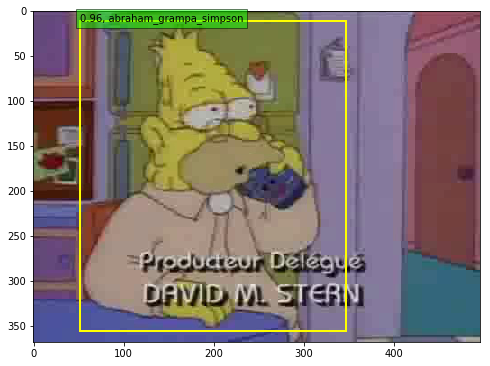

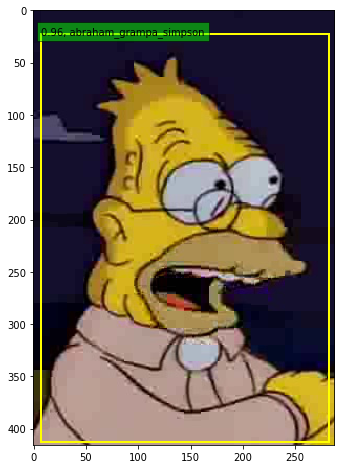

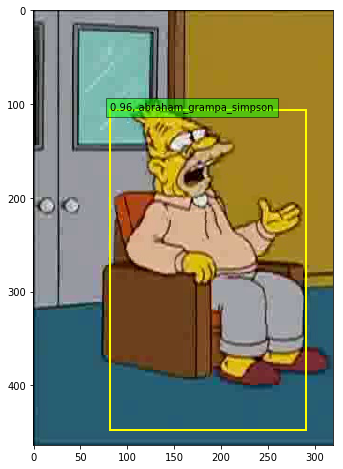

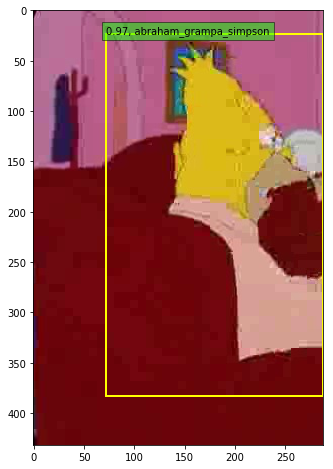

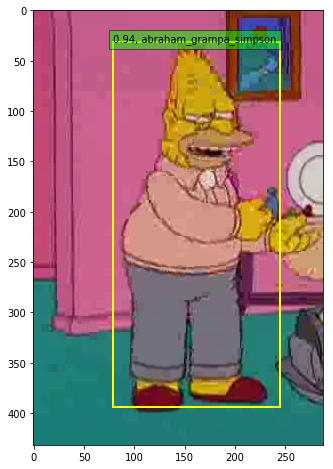

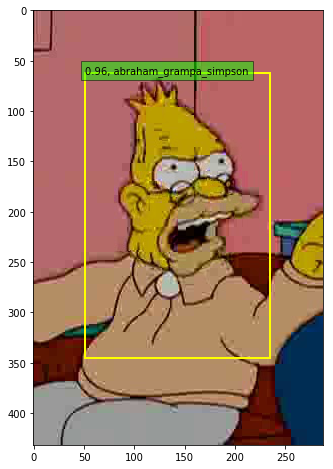

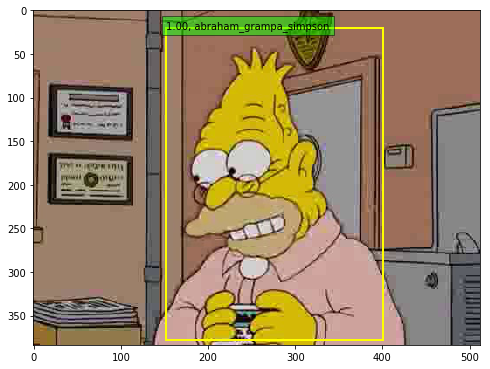

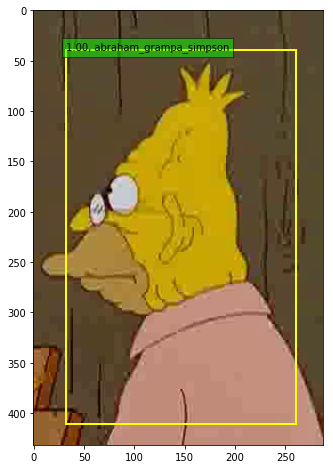

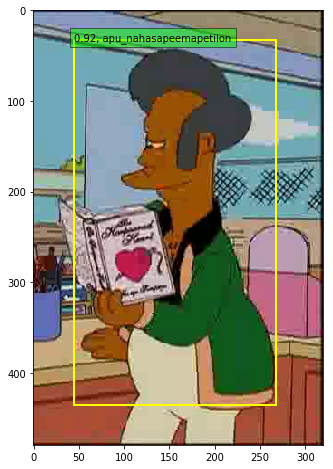

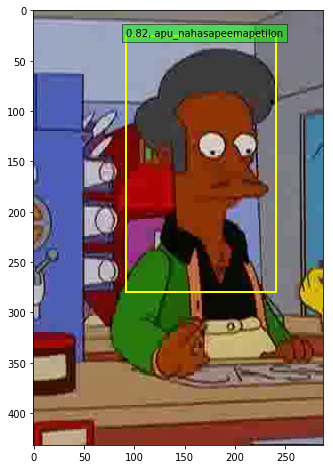

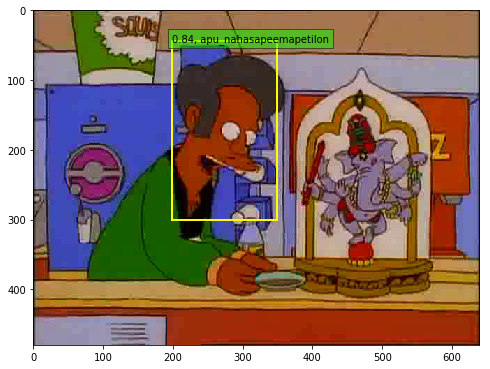

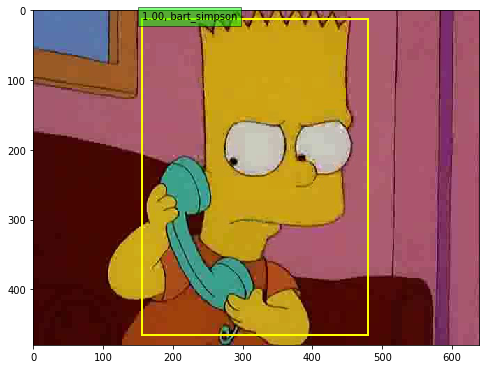

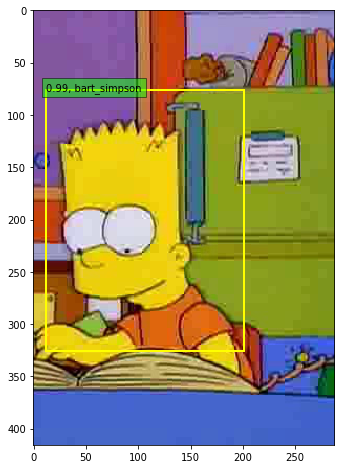

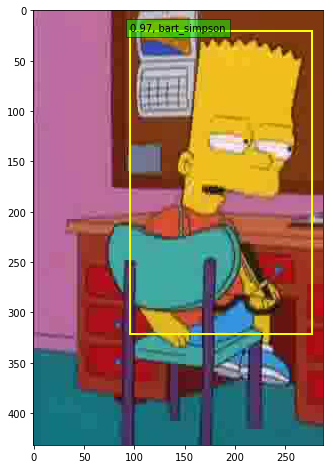

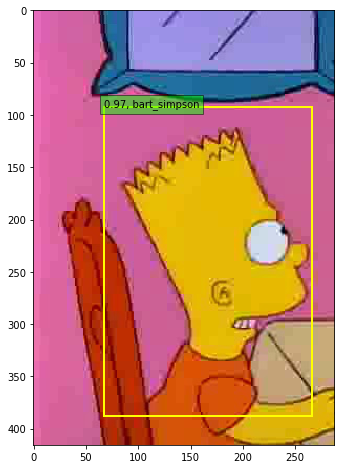

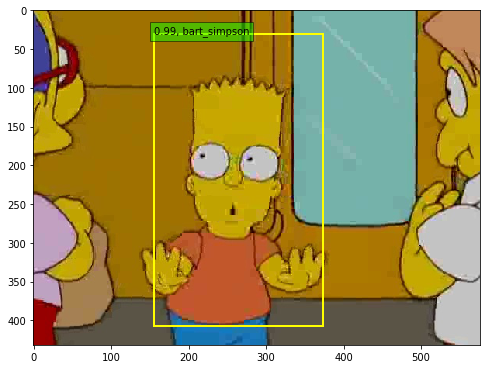

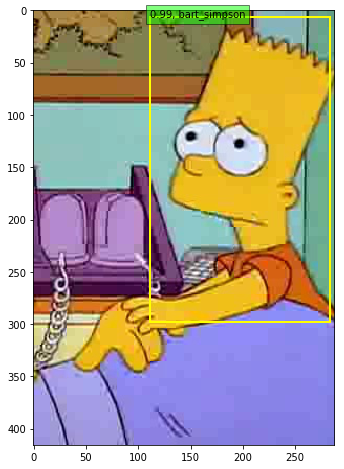

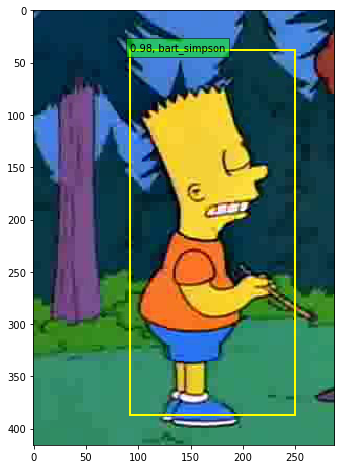

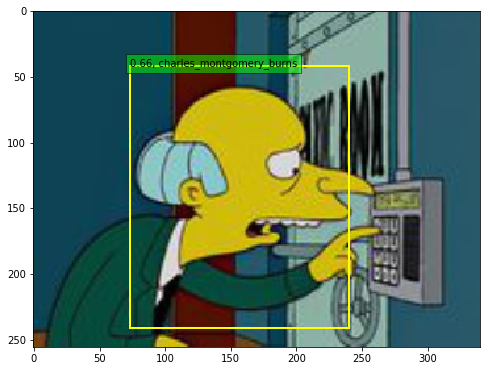

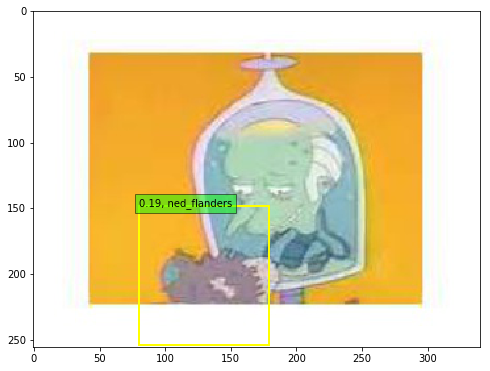

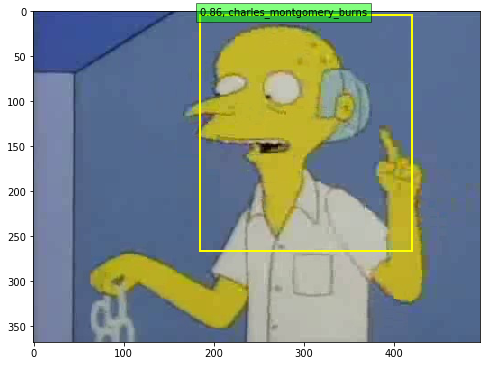

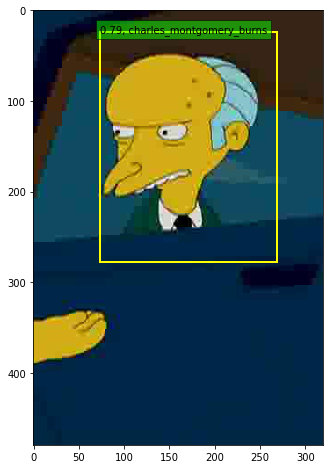

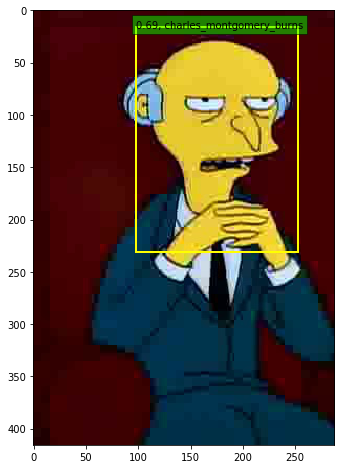

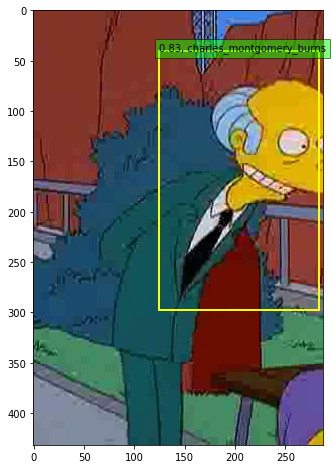

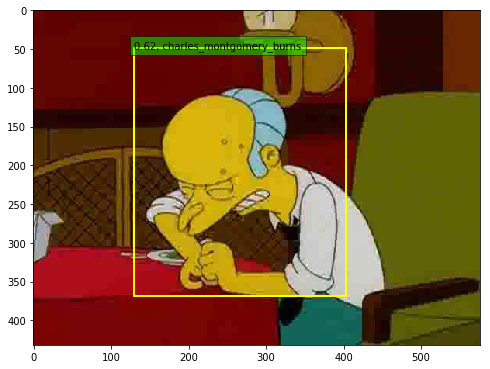

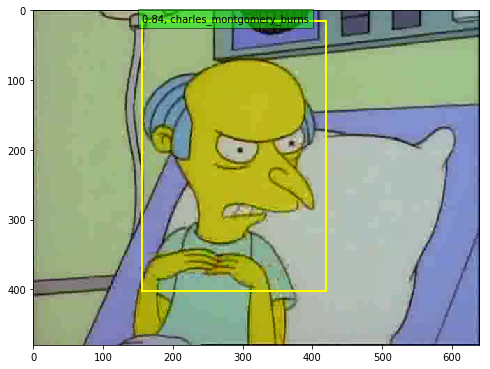

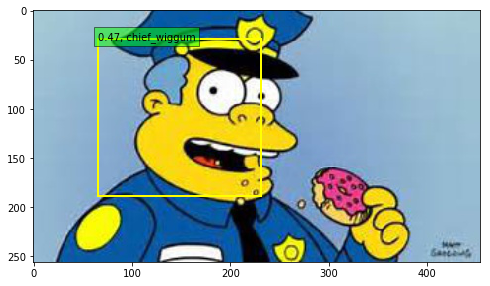

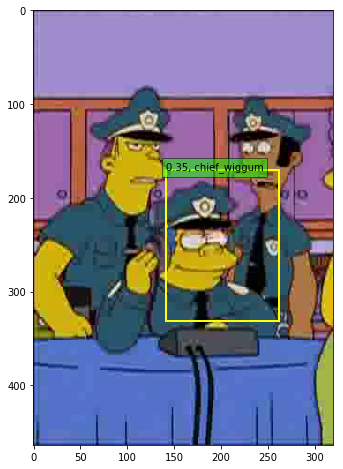

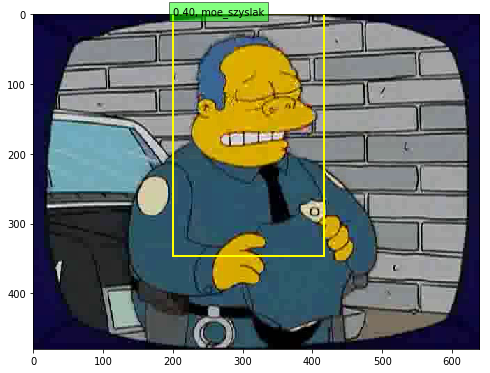

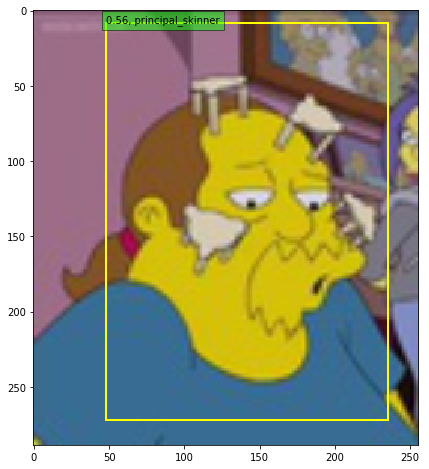

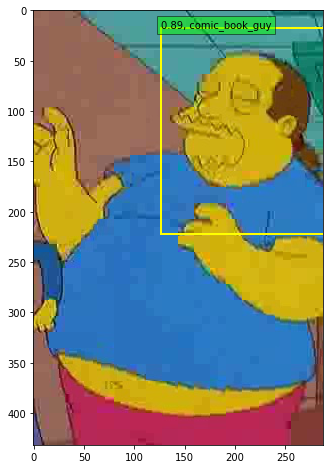

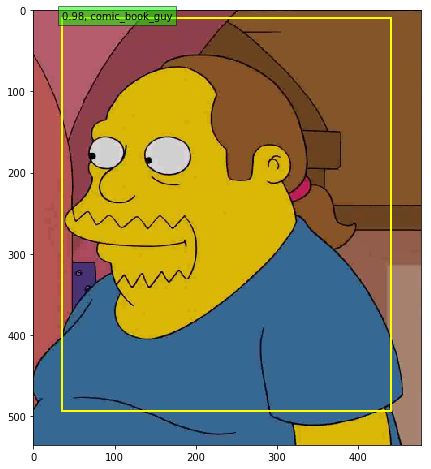

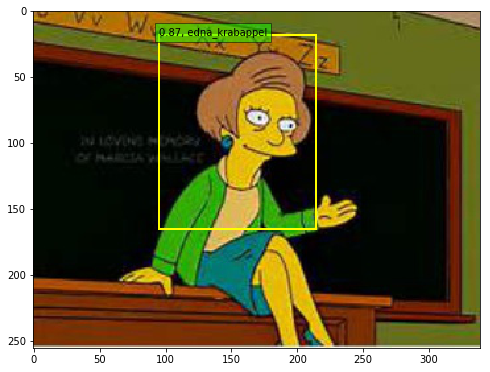

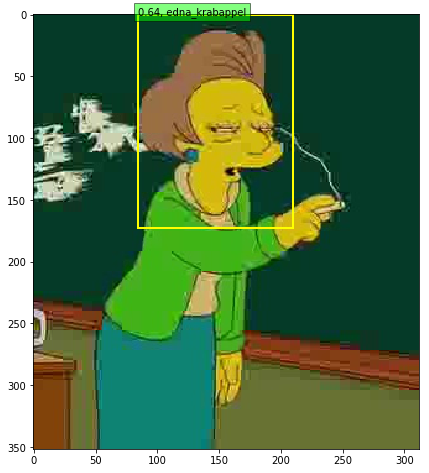

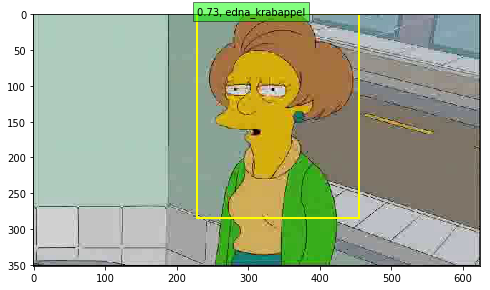

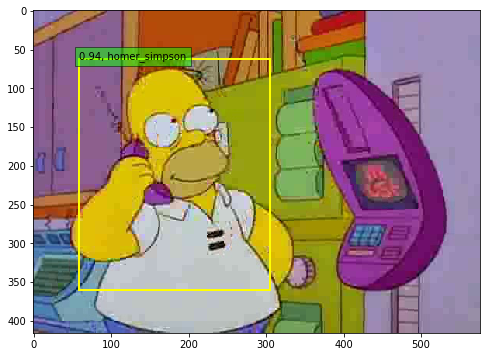

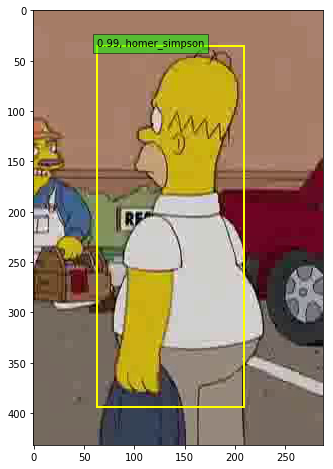

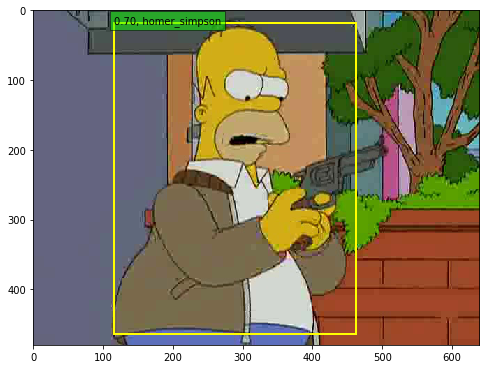

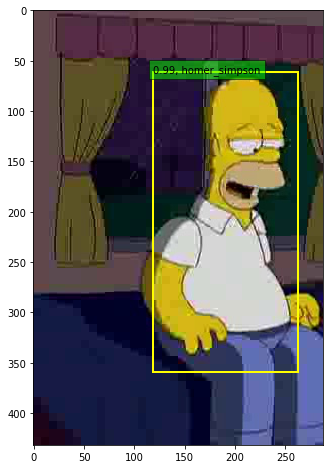

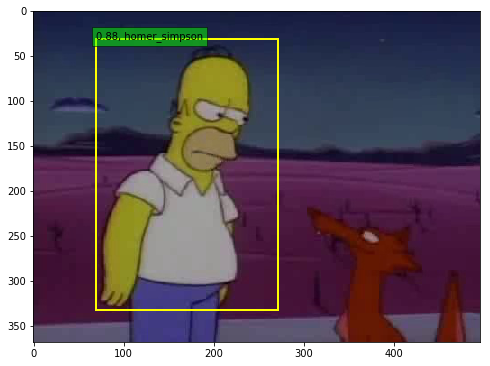

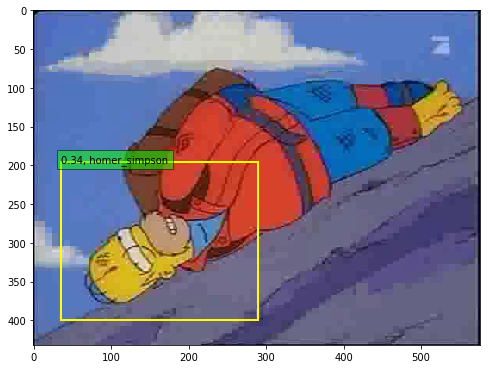

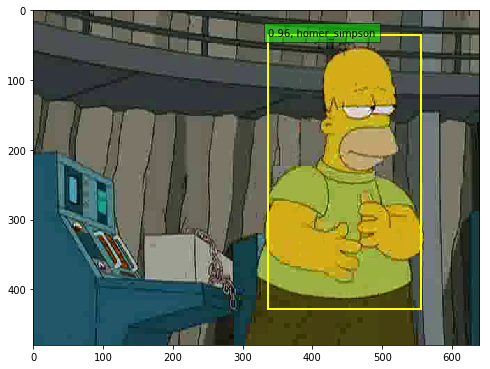

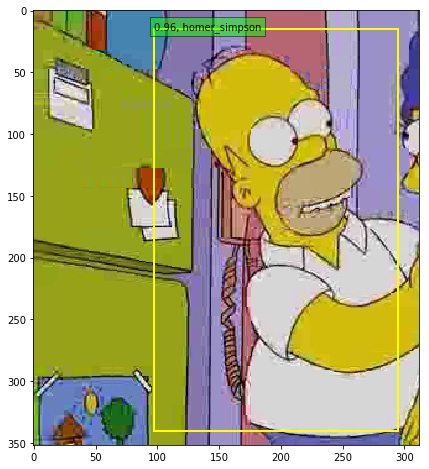

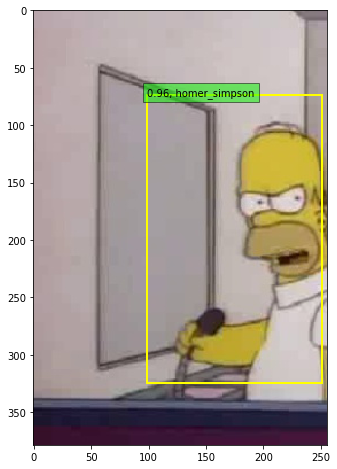

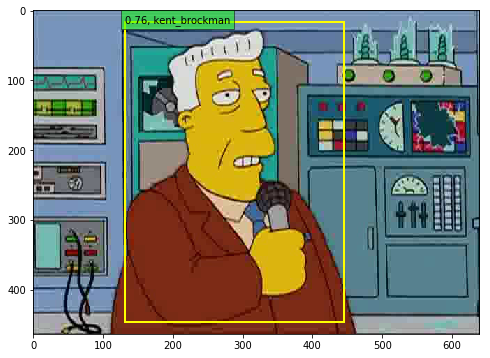

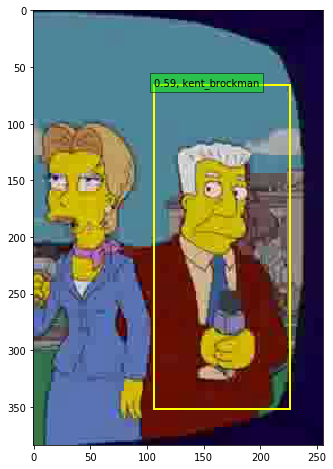

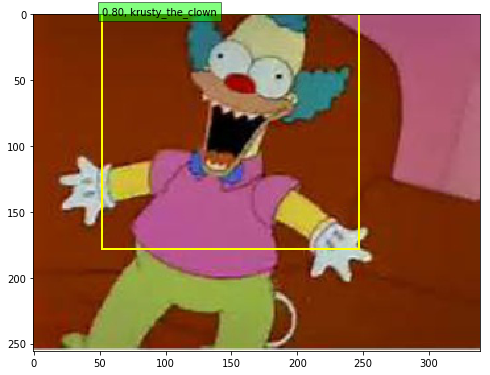

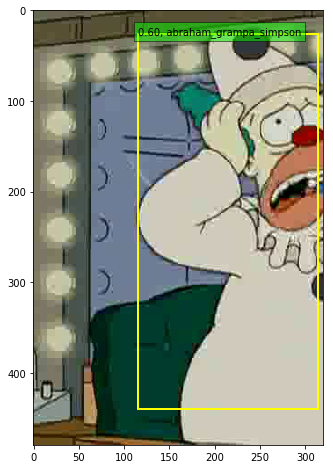

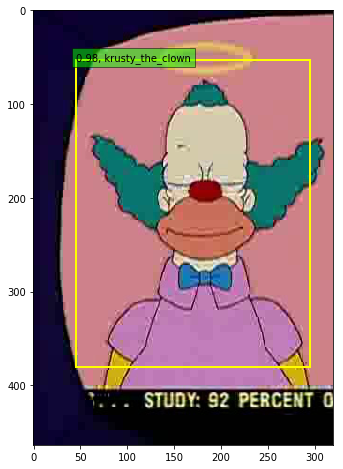

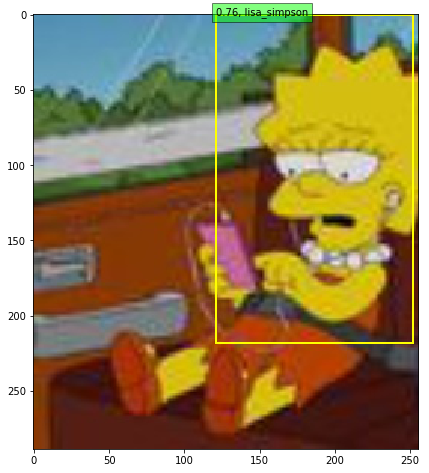

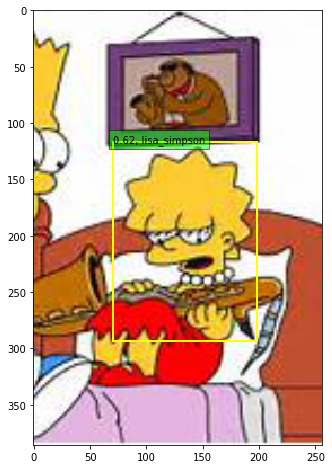

In [174]:
for i, img in enumerate(images):
    # Parse the outputs.
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]

    # Get detections with confidence higher than 0.6.
    #top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.4]
    top_indices = [np.where(det_conf==np.max(det_conf))[0][0]]
    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    colors = plt.cm.hsv(np.linspace(0, 1, 4)).tolist()

    plt.imshow(img / 255.)
    currentAxis = plt.gca()

    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
       # color = colors[label]
        name = [name for name, value in name_label.items() if value == label-1][0]
#         label_name = voc_classes[label - 1]
        display_txt = '{:0.2f}, {}'.format(score, name)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor="yellow", linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
    
    plt.show()

### 動画による結果確認（動画でもディテクションできていることを確認済み）

In [ ]:
import videotest_example